# VARIATIONAL AUTO ENCODER (VAE)

# Imports

In [13]:
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid


In [4]:
# create a transformer to apply to each datapoint in the dataset
# this transformer will convert the PIL image to a tensor
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '../data/raw'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


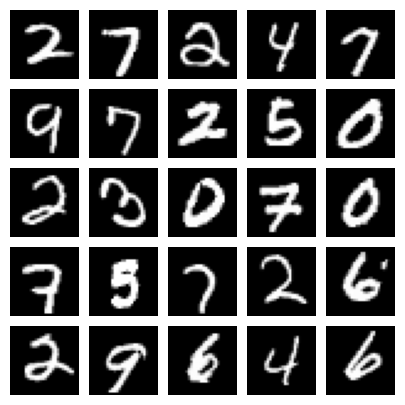

In [ ]:
# get 25 sample training images for visualization
data_iter = iter(train_loader)
image = next(data_iter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [7]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
    
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.log_var_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.log_var_layer(x)
        return mean, log_var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [10]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [15]:
def train(model, optimizer, epochs, device, x_dim=28*28):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


In [17]:
# Define hyperparameters
num_epochs = 50
learning_rate = 3e-4


model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

train(model, optimizer, epochs=num_epochs, device=device)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


	Epoch 1 	Average Loss:  199.9967821205916
	Epoch 2 	Average Loss:  167.03876253717132
	Epoch 3 	Average Loss:  160.9031213154737
	Epoch 4 	Average Loss:  158.05945736383555
	Epoch 5 	Average Loss:  155.10150680822204
	Epoch 6 	Average Loss:  152.71398121217655
	Epoch 7 	Average Loss:  151.03750169553422
	Epoch 8 	Average Loss:  149.69649207011688
	Epoch 9 	Average Loss:  148.63496243739567
	Epoch 10 	Average Loss:  147.6960993420023
	Epoch 11 	Average Loss:  146.85483783193342
	Epoch 12 	Average Loss:  146.082340163293
	Epoch 13 	Average Loss:  145.3553002399833
	Epoch 14 	Average Loss:  144.71766560804465
	Epoch 15 	Average Loss:  144.10679848901816
	Epoch 16 	Average Loss:  143.54831467158806
	Epoch 17 	Average Loss:  143.07127660684475
	Epoch 18 	Average Loss:  142.53369308548102
	Epoch 19 	Average Loss:  142.05647395724645
	Epoch 20 	Average Loss:  141.6864299548727
	Epoch 21 	Average Loss:  141.2460300044345
	Epoch 22 	Average Loss:  140.83727226040799
	Epoch 23 	Average Loss:  1

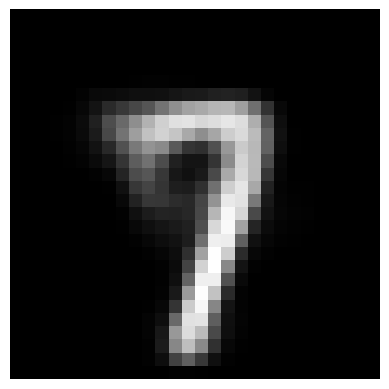

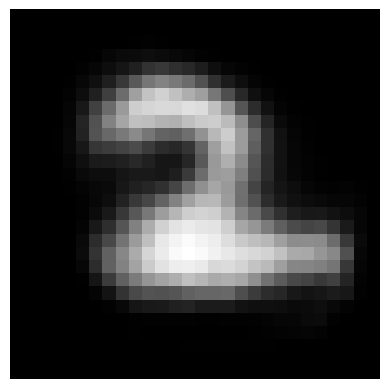

(None, None)

In [18]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

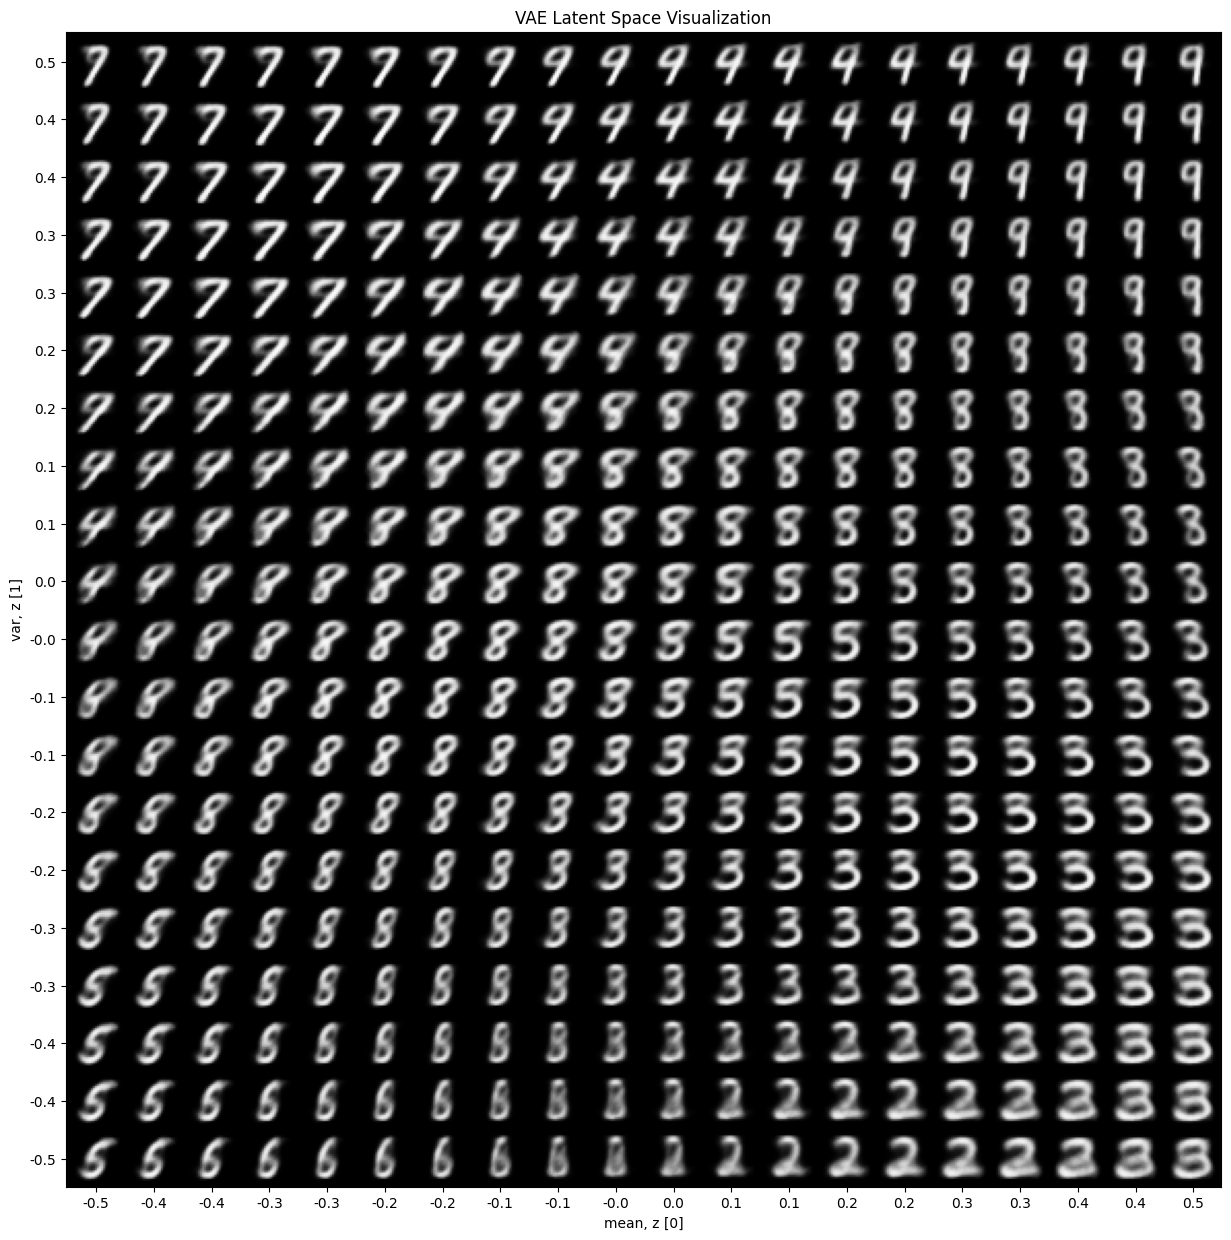

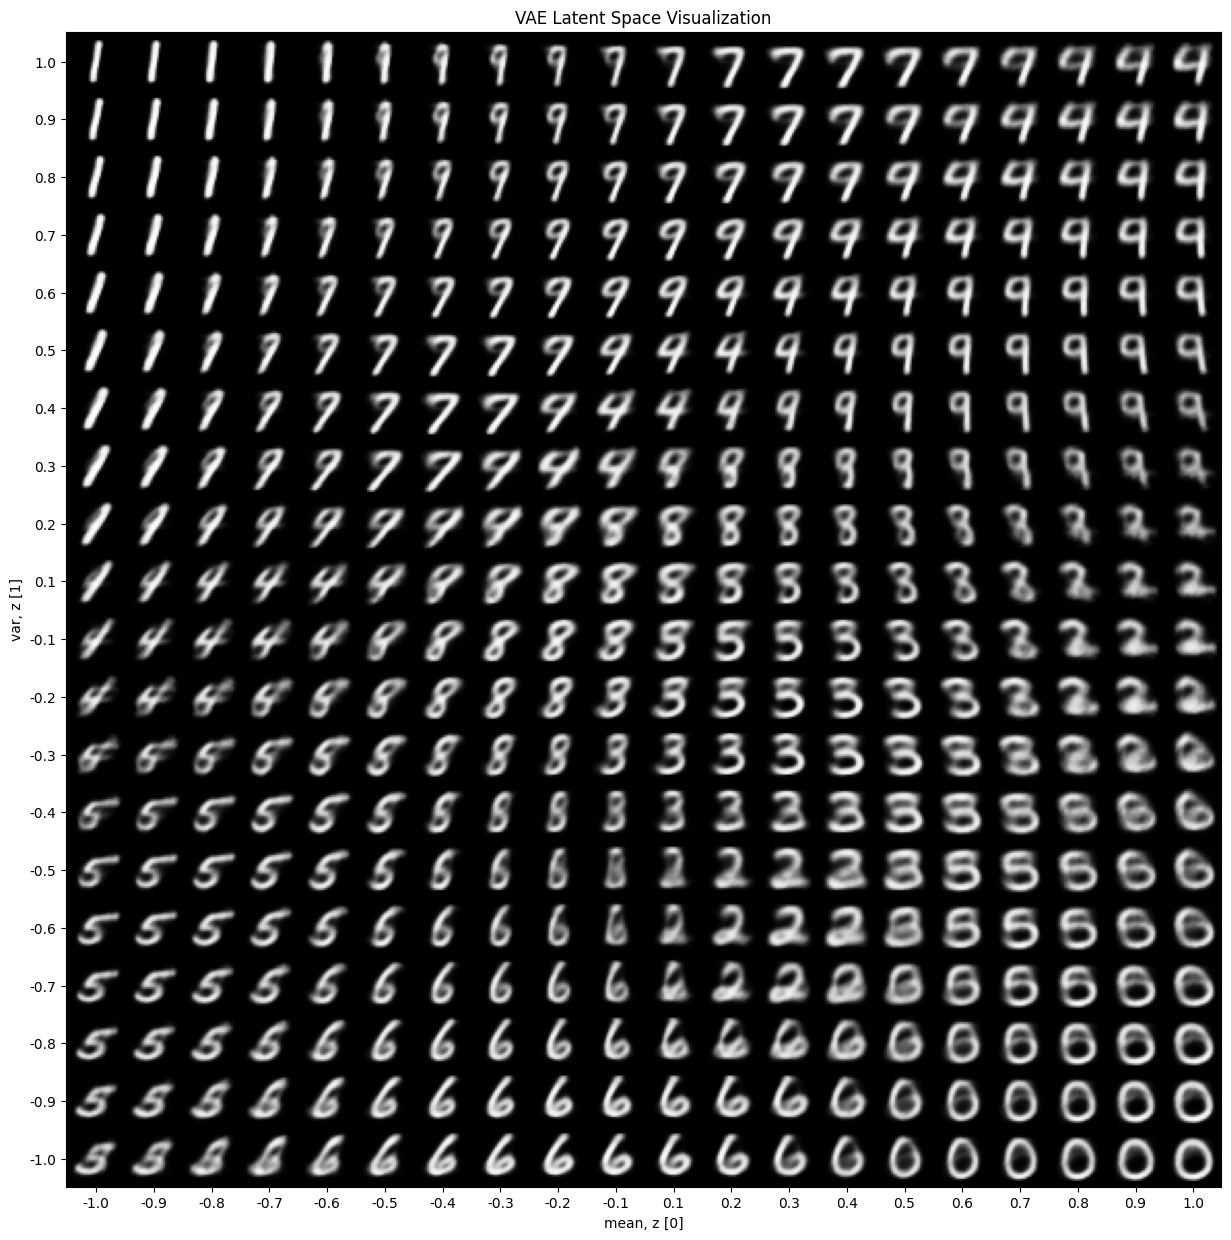

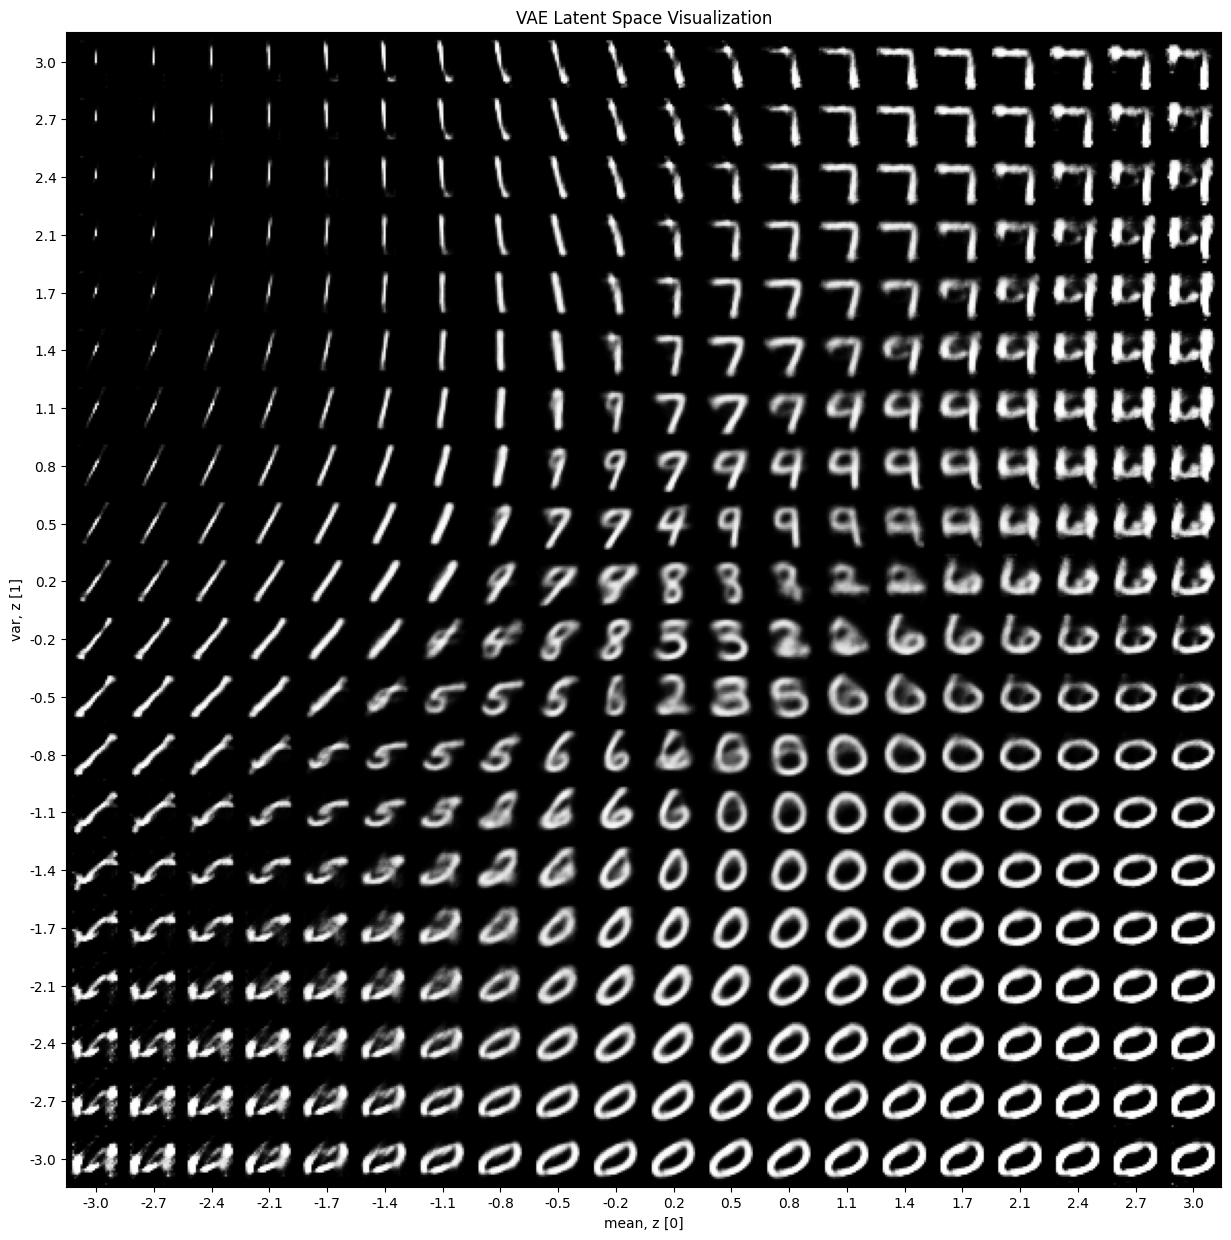

In [25]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale=0.5, n=20, digit_size=28, figsize=15)
plot_latent_space(model, scale=1.0, n=20, digit_size=28, figsize=15)
plot_latent_space(model, scale=3.0, n=20, digit_size=28, figsize=15)